# Домашнее задание 8. Generative Adversarial Networks

In [989]:
#импорт необходимых библиотек и модулей
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

## Задание

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$

При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

## План работы

[0. Генерация настоящих данных](#section_0)

[1. Dataset и Dataloader](#section_1)

[2. Генератор и Дискриминатор](#section_2)

[3. Обучение модели GAN](#section_3)

### 0. Генерация настоящих данных <a id='section_0'></a>

Функция  $y = \frac{sin(x)}{x} - \frac{x}{10}$ и ее график

In [990]:
#функция вычисления значений заданной функции
def func(x):
    """
    x -- значение переменной
    
    Возвращает значение функции y = (np.sin(x)/x) - (x/10) при заданном х
    """
    y = (np.sin(x)/x) - (x/10)
    return y

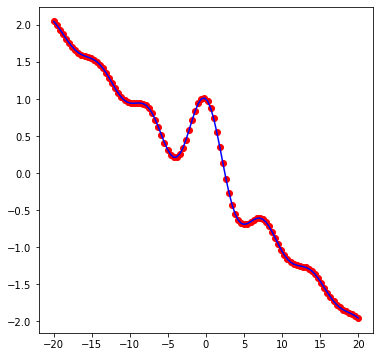

In [991]:
# визуализация графика функции

# создаем рисунок с координатную плоскость
fig, ax = plt.subplots(figsize=(6, 6))

# область графика
x = np.linspace(-20, 20, 100)

# рисуем точки графика
ax.scatter(x, y = func(x), color='red')

# рисуем график
plt.plot(x, func(x), color='blue')

# показываем график
plt.show()

Сгенерируем настроящие данные, используя функцию $y = \frac{sin(x)}{x} - \frac{x}{10}$

In [993]:
#функция генерации точек, принадлежащих графику заданной функции
def point_generator(ax, n):
    """
     [-ax, ax] -- отрезок значений x
    n -- количество значений x
    
    Возвращает датафрейм с координатами точек, принадлежащих графику функции y = (np.sin(x)/x) - (x/10)
    """
    points = pd.DataFrame([(x, func(x)) for x in np.random.uniform(-ax, ax, size=(1, n))[0]], columns=['x', 'y'])
    
    return points

In [994]:
#датасет с реальными данными (чем больше точек берем, тем лучше результат модели GAN)
df_train = point_generator(10, 500000)
df_train

,x,y
0,8.989359,-0.852015
1,1.013753,0.735931
2,-3.488151,0.251439
3,6.150730,-0.636545
4,-3.366518,0.270401
...,...,...
499995,-2.356811,0.535523
499996,7.424083,-0.619968
499997,-2.535841,0.478117
499998,9.502073,-0.958334


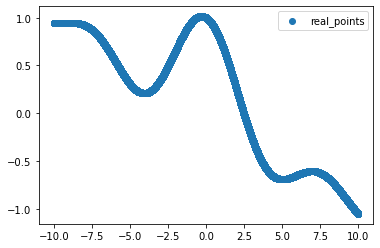

In [995]:
#отрисовка реальных данных
x,y = df_train.values.T
plt.scatter(x,y,label='real_points')
plt.legend()
plt.show()

Нормализуем данные для обучения

In [996]:
#без нормализации данных результат модели хуже
scaler = MinMaxScaler()
data_train = scaler.fit_transform(df_train)  
data_train = torch.FloatTensor(data_train).float()
data_train

tensor([[0.9495, 0.0978],
        [0.5507, 0.8651],
        [0.3256, 0.6310],
        ...,
        [0.3732, 0.7405],
        [0.9751, 0.0464],
        [0.5095, 0.9806]])

### 1. Dataset и Dataloader <a id='section_1'></a>

Создадим датасет и даталоадер для работы с данными

In [997]:
# класс датасета
class MyOwnClass(torch.utils.data.Dataset):
   
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        point = self._data[idx] 
       
        return point

In [998]:
# создание представителя датасета и его даталоадер
train_dataset = MyOwnClass(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [999]:
# элементы тренировочного даталоадера
for idx, batch in enumerate(train_loader):
    print(batch.shape) # 128 батчей с 2 признаками
    break

torch.Size([128, 2])


### 2. Генератор и Дискриминатор <a id='section_2'></a>

In [1000]:
# Функция для построения графиков
def plot_points(gen_points, real_points):
    # создаем рисунок с координатную плоскость
    fig, ax = plt.subplots(figsize=(6, 6))

    #отрисовка реальных точек
    a,b = (real_points.detach()).T
    plt.scatter(a,b, color='green',label='real_points') 
    
    #отрисовка сгенерированных точек
    x, y = (gen_points.detach()).T
    plt.scatter(x,y, color='red', label='generated_points') 

    plt.legend()
    plt.show()

Класс Генератора

In [1001]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
             nn.Linear(1024, 2),
             nn.Linear(2, 2),
             nn.Tanh()
        )
        
    def forward(self, z):
        new_point = self.model(z)
        new_point = new_point.reshape(-1, 2)
        return new_point 

Класс кастомного слоя

In [1002]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные 
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

Класс Дискриминатора

In [1003]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid()
        )
  

    def forward(self, img):
        img_flat = img
        validity = self.model(img_flat)
        return validity

### 3. Обучение модели GAN <a id='section_3'></a>

In [1004]:
n_epochs = 20  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения

batch_size = 128

In [1005]:
generator = Generator()
discriminator = Discriminator()

# опитимизатор для каждой сети
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# функция ошибки
adversarial_loss = torch.nn.BCELoss()

In [1006]:
d_loss_history = []
g_loss_history = []

<Figure size 432x288 with 0 Axes>

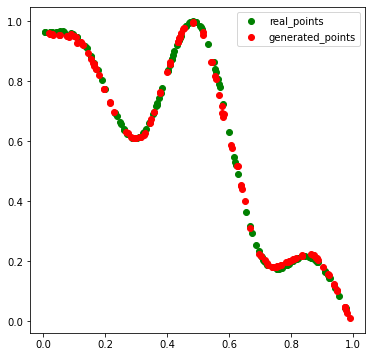

[Epoch 19/20] [Batch 3786/3906]|[D loss: 0.6942075490951538] [G loss: 0.6934964656829834]


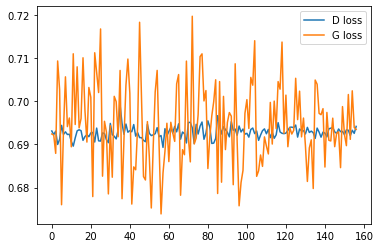

In [1007]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


for epoch in range(n_epochs):
    for i, points in enumerate(train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0) #(B,1) -- столбец-лейблов 1
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0)  #(B,1)  -- столбец-лейблов 0

        real_points = points.type(torch.FloatTensor) #(B,2) -- реальные данные

        # Генерация шума (B,latent_dim)
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)   #(B,2) -- сгенерированные данные
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_points)  #(B,1)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points) #(B,1)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))) #(B,latent_dim)
        
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)  #(B,2)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_points)  #(B,1)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()
                display.clear_output(wait=False)
                plot_points(gen_points, real_points)
                
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                d_loss = d_loss.detach()  #новый тензор без градиента
                g_loss = g_loss.detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()        